In [595]:
import os
import wfdb
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from mlp_mixerECG import FeedForward, ECGMixerBlock, MLPMixerForECG
from MlpMixerECG import MlpBlock, MixerBlock, MlpMixer

In [596]:
class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 데이터셋의 루트 디렉토리 (예: 'D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')
        transform: 데이터에 적용할 변환
        """
        self.root_dir = root_dir
        self.transform = transform
        self.records = self._load_records()

    def _load_records(self):
        records = []
        # MI_F_ecg와 NOT_MI_F_ecg를 포함한 레이블 목록으로 업데이트
        for label in ['NOT_MI_M_ecg', 'NOT_MI_F_ecg']:
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir):
                patient_dir = os.path.join(label_dir, patient)
                for session in os.listdir(patient_dir):
                    session_dir = os.path.join(patient_dir, session)
                    for file in os.listdir(session_dir):
                        if file.endswith('.hea'):
                            record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
                            records.append((record_path, 0))
        
        for label in ['MI_M_ecg', 'MI_F_ecg']:
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir):
                patient_dir = os.path.join(label_dir, patient)
                for session in os.listdir(patient_dir):
                    session_dir = os.path.join(patient_dir, session)
                    for file in os.listdir(session_dir):
                        if file.endswith('.hea'):
                            record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
                            records.append((record_path, 1))

        return records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec_path, label = self.records[idx]
        record = wfdb.rdrecord(rec_path)
        data = record.p_signal  # ECG 데이터 로드 및 변환

        # NaN 값을 0으로 변환
        if np.isnan(data).any():
            data = np.nan_to_num(data)


        if self.transform:
            data = self.transform(data)

        return data, label


In [597]:
# records = []

# for label in ['MI_M_ecg', 'MI_F_ecg']:
#     label_dir = os.path.join('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed', label)
#     for patient in os.listdir(label_dir):
#                 patient_dir = os.path.join(label_dir, patient)
#                 for session in os.listdir(patient_dir):
#                     session_dir = os.path.join(patient_dir, session)
#                     for file in os.listdir(session_dir):
#                         if file.endswith('.hea'):
#                             record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
#                             records.append((record_path, 1))

# for label in ['NOT_MI_M_ecg', 'NOT_MI_F_ecg']:
#     label_dir = os.path.join('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed', label)
#     for patient in os.listdir(label_dir):
#                 patient_dir = os.path.join(label_dir, patient)
#                 for session in os.listdir(patient_dir):
#                     session_dir = os.path.join(patient_dir, session)
#                     for file in os.listdir(session_dir):
#                         if file.endswith('.hea'):
#                             record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
#                             # MI_M_ecg 및 MI_F_ecg는 1로, NOT_MI_M_ecg 및 NOT_MI_F_ecg는 0으로 레이블 설정
#                             records.append((record_path, 0))

# print(label_dir)
# print(patient_dir)
# print(session_dir)
# print(file)
# print(records)

In [598]:
# records

In [599]:
# Z-점수 정규화를 위한 Custom Transform 클래스 정의
class Standardize:
    def __call__(self, sample):
        return (sample - sample.mean()) / sample.std()

# 정규화 Transform을 정의합니다.
transform = transforms.Compose([
    Standardize()
])

In [600]:
# 데이터셋 및 DataLoader 초기화
# dataset = ECGDataset('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')
dataset = ECGDataset(root_dir='D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')


In [601]:
# 데이터셋에서 각 항목에 대해 nan과 inf 값이 있는지 확인
has_nan = False
has_inf = False

for i in range(len(dataset)):
    data, label = dataset[i]  # __getitem__ 호출
    tensor_data = torch.tensor(data)

    # nan 값이 있는지 확인
    if torch.isnan(tensor_data).any():
        has_nan = True
        print(f'Found NaN in item {i}')
    
    # inf 값이 있는지 확인
    if torch.isinf(tensor_data).any():
        has_inf = True
        print(f'Found Inf in item {i}')

if not has_nan and not has_inf:
    print('No NaN or Inf values found in the dataset')

No NaN or Inf values found in the dataset


<Figure size 2400x1800 with 0 Axes>

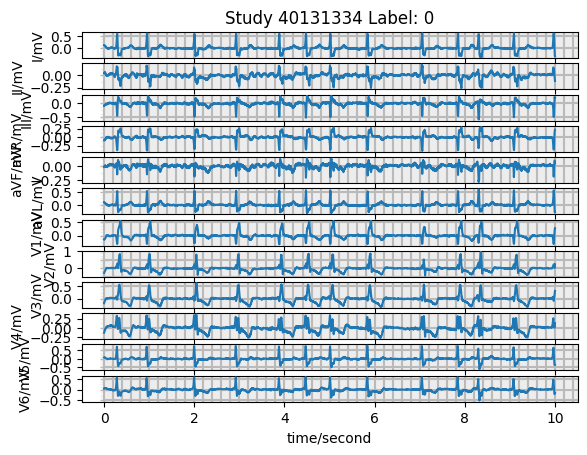

<Figure size 2400x1800 with 0 Axes>

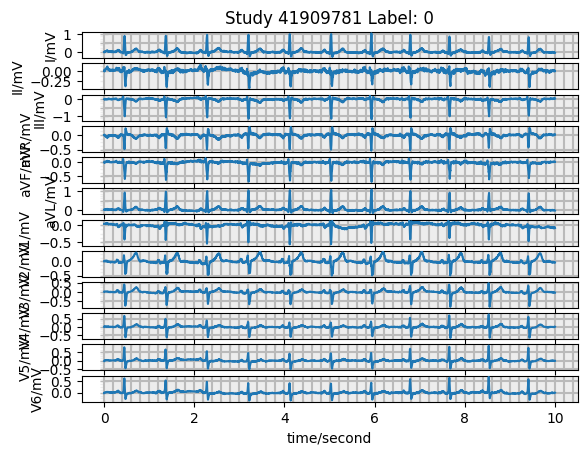

In [602]:
# 처음 2개 데이터 항목 시각화
for i in range(2):
    rec_path, label = dataset.records[i]  # 데이터셋에서 경로와 레이블을 가져옴
    record = wfdb.rdrecord(rec_path)  # rdrecord를 사용하여 데이터 로드

    # plot_wfdb를 사용하여 시각화
    plt.figure(figsize=(24, 18))
    wfdb.plot_wfdb(record=record, title=f'Study {record.record_name} Label: {label}', ecg_grids='all')
    plt.show()

In [603]:
print(dataset.records[i])

('D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed\\NOT_MI_M_ecg\\p1001\\p10012438\\41909781', 0)


In [604]:
# 첫 번째 데이터 항목 로드
first_data, first_label = dataset[0]

# ECG 데이터와 레이블 출력
print("First ECG Data Shape:", first_data.shape)
print("First ECG Data Label:", first_label)


First ECG Data Shape: (5000, 12)
First ECG Data Label: 0


In [605]:
print(len(dataset))

1742


In [606]:
# 데이터셋 크기
total_size = len(dataset)

# 훈련 세트와 테스트 세트의 크기 계산
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# 데이터셋을 훈련 세트와 테스트 세트로 무작위 분할
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 분할된 데이터셋 크기 확인
print(f'Total dataset size: {total_size}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')


Total dataset size: 1742
Train dataset size: 1393
Test dataset size: 349


In [607]:
print(len(train_loader))
print(len(test_loader))

44
11


In [608]:
model = MlpMixer(num_channels=12, hidden_dim=64, mlp_token_dim=64, mlp_channel_dim=64, seq_len=5000, num_blocks=2, num_classes=2)

# GPU가 사용 가능한지 확인하고, 사용 가능하다면 GPU를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 GPU로 이동시킵니다.

print(device)



cuda


In [609]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
# # 학습률 스케줄러 설정
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.95, patience=10)


In [610]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()
        inputs = inputs.permute(0, 2, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%')

    return epoch_acc

In [611]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device).float()  
            labels = labels.to(device).long()
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%')
    return epoch_acc


In [612]:
num_epochs = 20

Epoch 1/20


Training Loss: 0.7004, Accuracy: 50.3948%
Validation Loss: 0.6972, Accuracy: 47.5645%
Epoch 2/20
Training Loss: 0.6928, Accuracy: 50.7538%
Validation Loss: 0.6948, Accuracy: 49.5702%
Epoch 3/20
Training Loss: 0.6914, Accuracy: 51.2563%
Validation Loss: 0.6940, Accuracy: 49.5702%
Epoch 4/20
Training Loss: 0.6908, Accuracy: 52.8356%
Validation Loss: 0.6942, Accuracy: 48.1375%
Epoch 5/20
Training Loss: 0.6897, Accuracy: 56.1378%
Validation Loss: 0.6937, Accuracy: 51.0029%
Epoch 6/20
Training Loss: 0.6881, Accuracy: 54.4149%
Validation Loss: 0.6946, Accuracy: 47.2779%
Epoch 7/20
Training Loss: 0.6858, Accuracy: 60.3015%
Validation Loss: 0.6950, Accuracy: 49.2837%
Epoch 8/20
Training Loss: 0.6822, Accuracy: 62.6705%
Validation Loss: 0.6967, Accuracy: 45.8453%
Epoch 9/20
Training Loss: 0.6783, Accuracy: 63.0294%
Validation Loss: 0.7009, Accuracy: 46.4183%
Epoch 10/20
Training Loss: 0.6738, Accuracy: 62.6705%
Validation Loss: 0.6980, Accuracy: 48.9971%
Epoch 11/20
Training Loss: 0.6668, Accur

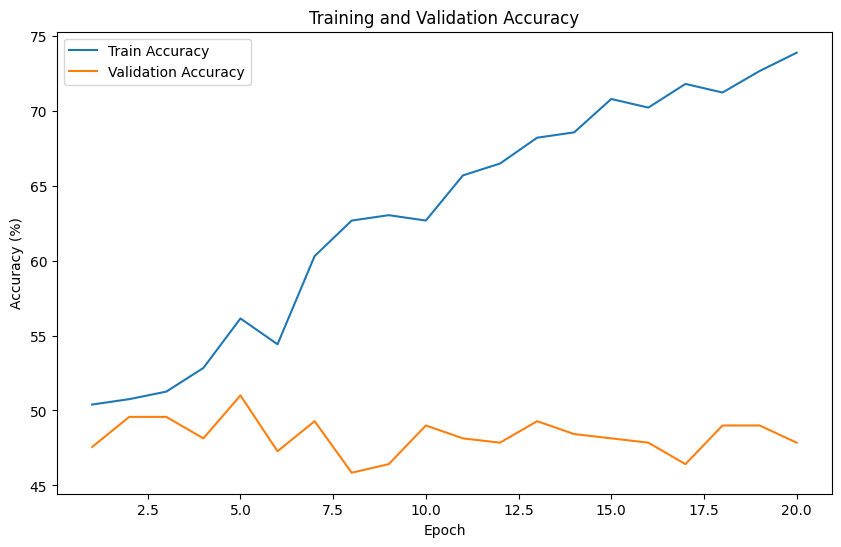

In [613]:
# 정확도 기록을 저장할 리스트 초기화
train_accuracies = []
validation_accuracies = []
    
# 훈련 및 검증 루프
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_acc = train(model, train_loader, criterion, optimizer, device)
    val_acc = validate(model, test_loader, criterion, device)
    
    # 정확도 기록
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

# 정확도 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
